n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  2.363992E+01 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |  1.239636E+01 |  0.000000E+00 |             f
     3 |       60 |      2 |  0.000000E+00 |  5.4620972973 |  1.0000000000 |         ideal
     4 |       70 |      2 |  0.000000E+00 |  2.3938570636 |  0.000000E+00 |             f
     5 |       80 |      2 |  0.000000E+00 |  1.1200787779 |  0.000000E+00 |             f
     6 |       90 |      3 |  0.000000E+00 |  0.1858089725 |  0.1785481247 |             f
     7 |      100 |      4 |  0.000000E+00 |  0.0096392745 |  0.0639961700 |         ideal
     8 |      110 |      6 |  0.000000E+00 |  0.0016302512 |  0.0912676400 |         ideal
     9 |      120 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0246228920 |             f
    10 |      130 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1055074321 |         ideal

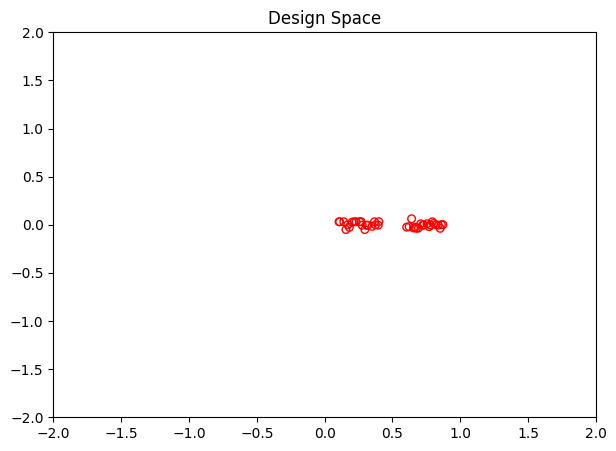

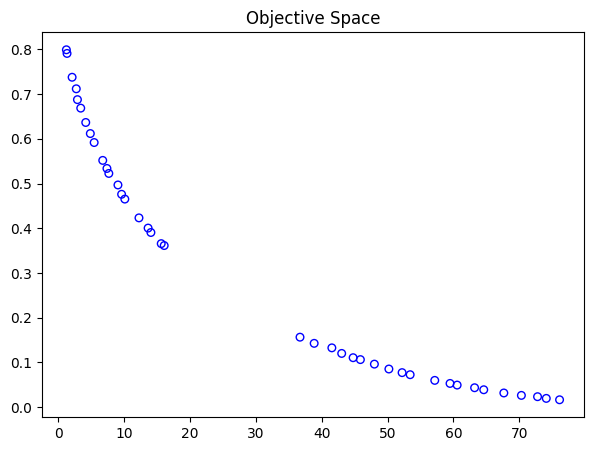

Scale f1: [1.2326505781273076, 76.11408901037468]
Scale f2: [0.016274681752497733, 0.7993666679801954]


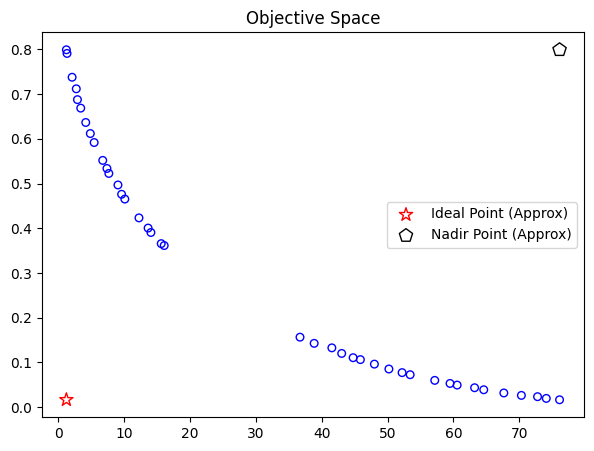

Scale f1: [0.0, 1.0]
Scale f2: [0.0, 1.0]


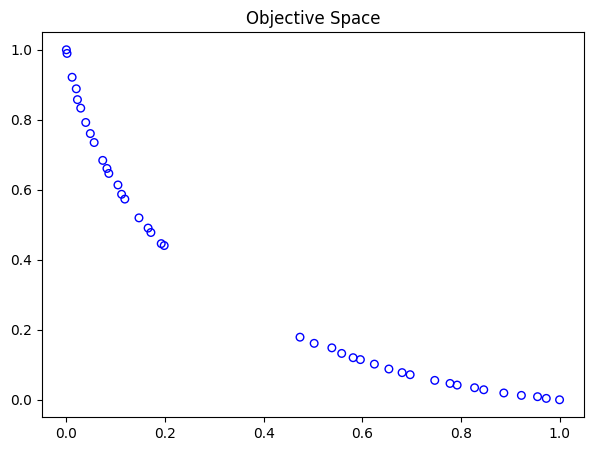

Best regarding ASF: Point 
i = 38
F = [43.03297727  0.11997261]


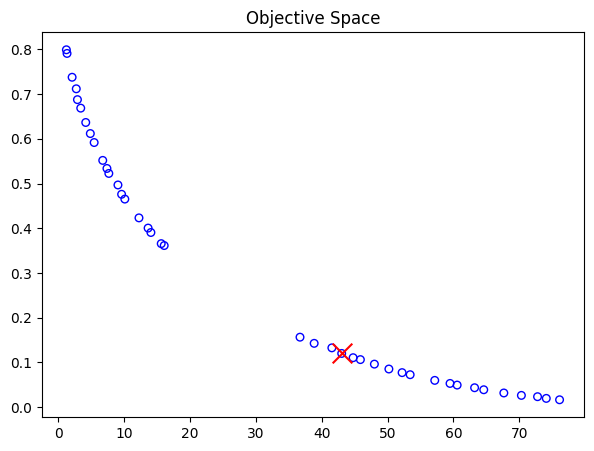

Best regarding Pseudo Weights: Point 
i = 33
F = [5.94829771e+01 5.28349683e-02]


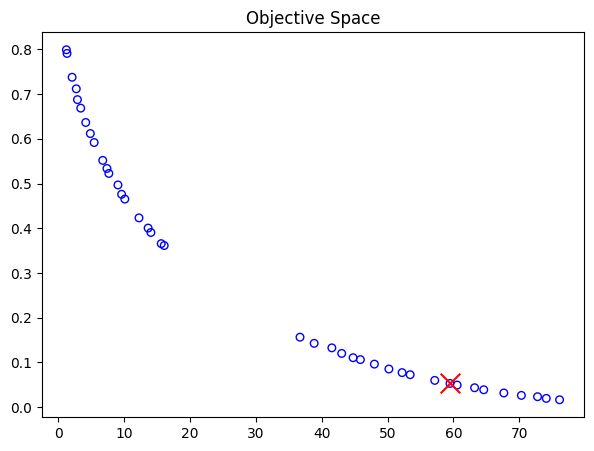

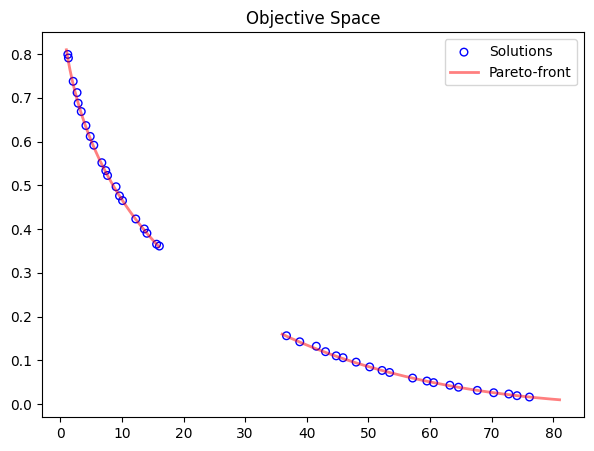

40
At least one feasible solution in Generation 0 after 40 evaluations.


In [2]:
# each objective function has to be minimized ->maximization objectives need to be multiplied by -1
# each constraint has to be formulated as <= 0 ->change sign by multiplying by -1
# normalize constraints to make them operating on the same scale and give them equal importance: divide by the product of the coefficients

# element wise problem formulation

# problem formulation
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=2, xl=np.array([-2,-2]), xu=np.array([2,2])) # set the correct attributes

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]
problem = MyProblem()

# algorithm is set up as an object to enable its usage for solving the problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

# instead of using default hyper parameters I adapt the algorithm to create my own version of it
# further hyper parameter adaptions can be done to enable a faster convergence
algorithm = NSGA2(
    pop_size=40, # makes the algorithm greedier
    n_offsprings=10, # makes the algorithm greedier
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# define a termination criterion to start the optimization procedure

from pymoo.termination import get_termination

termination = get_termination("n_gen", 40) # limit of iterations is set to 40 iterations of the algorithm

# solve the problem with the algorithm and the termination criterion

from pymoo.optimize import minimize

res = minimize (problem, algorithm, termination, seed=1, save_history=True, verbose=True) # verbose delivers some printouts during algorithm execution

X=res.X
F=res.F

# visualization of the results

import matplotlib.pyplot as plt

# design space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

# objective space
# pareto optimal solutions 
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

# post processing
# analysis of scales 
# we assume the ideal and nadir points (also referred to as boundary points) and the Pareto-front are not known
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

# nadir point
# ideal point
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

# plot boundary points
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()

# normalize objective values regarding the boundary points
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

plt.figure(figsize=(7, 5))
plt.scatter(nF[:, 0], nF[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

# decompostion for multi criteria decision making
# vector of weights with only positive float numbers summing up to one and a length equal to the number of objectives

weights = np.array([0.2, 0.8])

# decomposition with ASF
from pymoo.decomposition.asf import ASF
decomp = ASF()

i = decomp.do(nF, 1/weights).argmin()

print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

# decomposition with pseudo weights
from pymoo.mcdm.pseudo_weights import PseudoWeights

i = PseudoWeights(weights).do(nF)

print("Best regarding Pseudo Weights: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

# convergence analysis

from pymoo.util.misc import stack

class MyTestProblem(MyProblem):

    def _calc_pareto_front(self, flatten=True, *args, **kwargs):
        f2 = lambda f1: ((f1/100) ** 0.5 - 1)**2
        F1_a, F1_b = np.linspace(1, 16, 300), np.linspace(36, 81, 300)
        F2_a, F2_b = f2(F1_a), f2(F1_b)

        pf_a = np.column_stack([F1_a, F2_a])
        pf_b = np.column_stack([F1_b, F2_b])

        return stack(pf_a, pf_b, flatten=flatten)

    def _calc_pareto_set(self, *args, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)

problem = MyTestProblem()

pf_a, pf_b = problem.pareto_front(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=True)

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='b', label="Solutions")
plt.plot(pf_a[:, 0], pf_a[:, 1], alpha=0.5, linewidth=2.0, color="red", label="Pareto-front")
plt.plot(pf_b[:, 0], pf_b[:, 1], alpha=0.5, linewidth=2.0, color="red")
plt.title("Objective Space")
plt.legend()
plt.show()

# analyse history of the algorithm
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               ("n_gen", 40),
               seed=1,
               save_history=True,
               verbose=False)

X, F = res.opt.get("X", "F")

hist = res.history
print(len(hist))

# evaluate algorithm wiht different metrics
# Hypervolume or IGD

n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

    k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

# Algorithm performance analysis

## With known or approximated Pareto-front

### Check when the first feasible solution has been found:

In [3]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 0 after 40 evaluations.


Whole population feasible in Generation 8 after 120 evaluations.


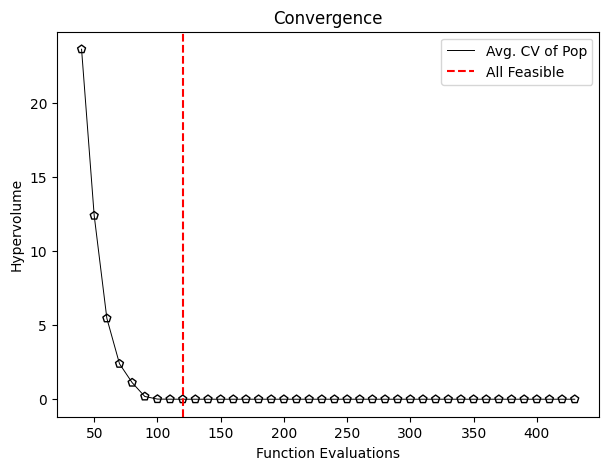

In [4]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

## With unknown Pareto-front

Hypervolume is a well known performance indicator for multi-objective problems. 

In [5]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

Convergence

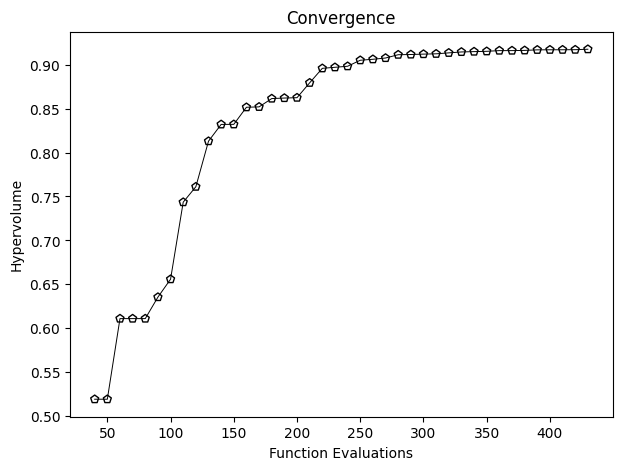

In [7]:
# define a reference point which shall be larger than the maximum value of the Pareto front
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

Running metric

c:\Users\M.Frank\Documents\GitHub\2025_Multi_Objective_CMS\.venv\Lib\site-packages\pymoo\termination\ftol.py:14: RuntimeWarning: invalid value encountered in divide
  return np.max(np.abs((a - b) / norm))


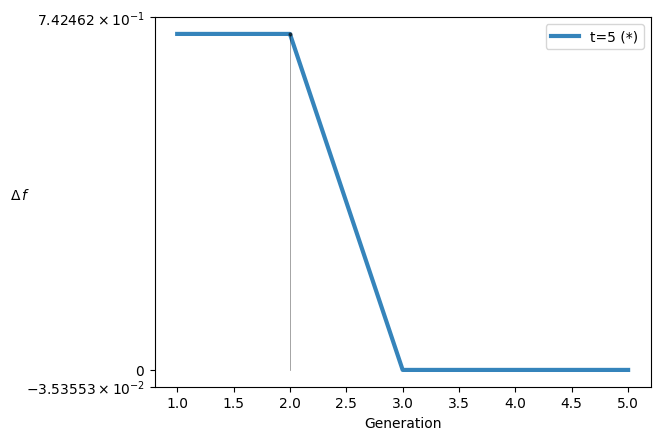

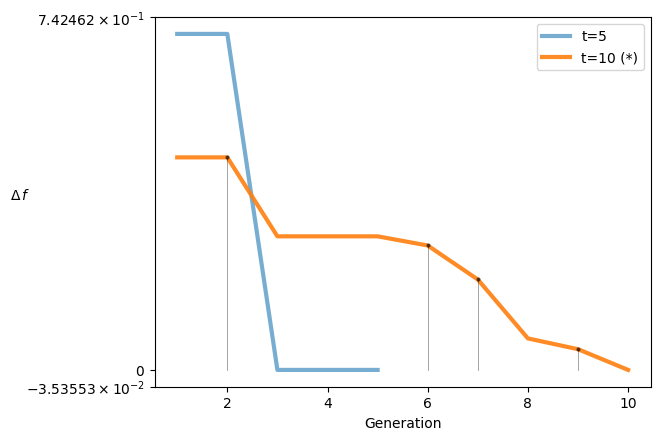

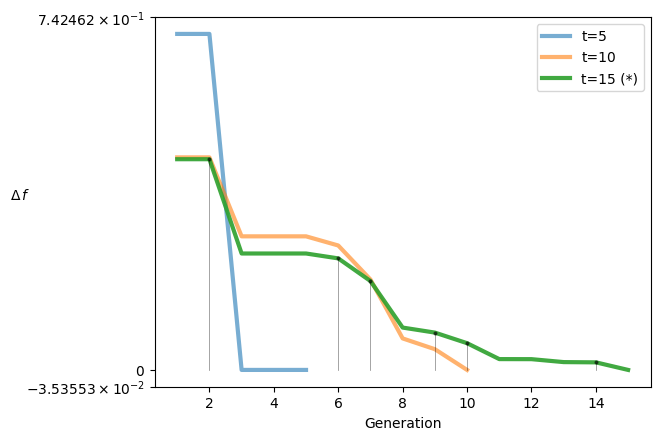

In [8]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=5,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res.history[:15]:
    running.update(algorithm)

Running metric for all generations

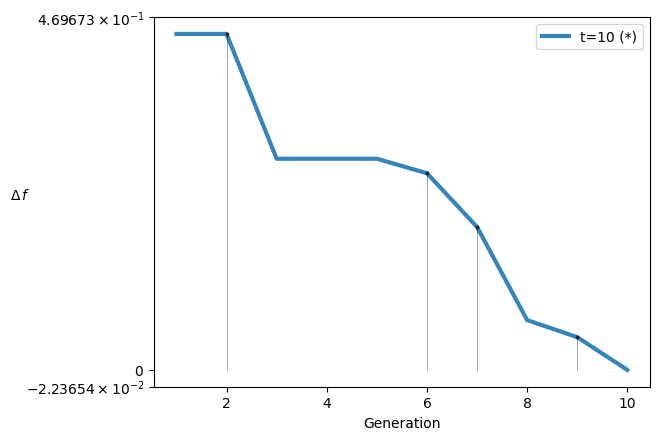

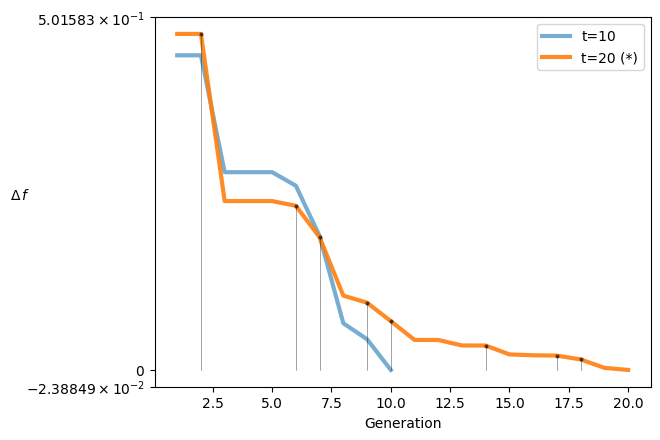

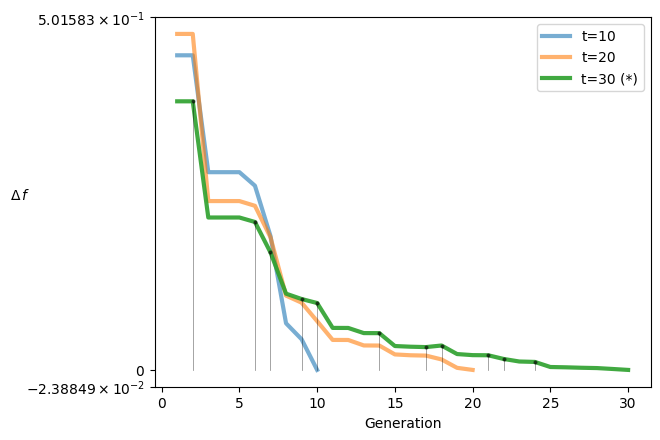

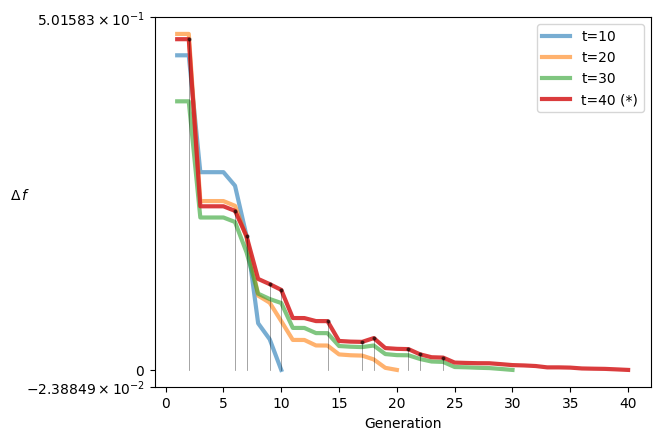

In [9]:
from pymoo.util.running_metric import RunningMetric

running = RunningMetricAnimation(delta_gen=10,
                        n_plots=4,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.update(algorithm)

## Pareto-front approximation

IGD/GD/IGD+/GD+

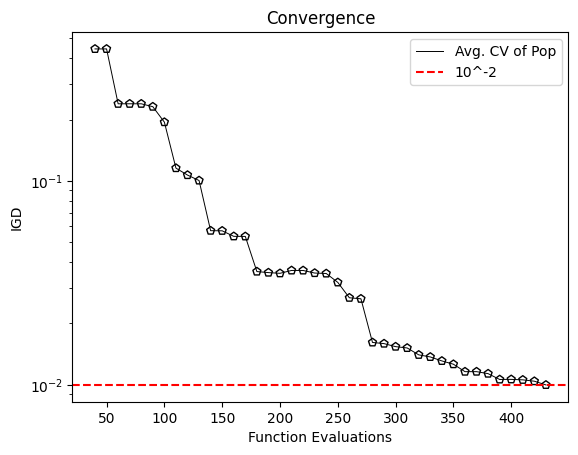

In [10]:
from pymoo.indicators.igd import IGD

metric = IGD(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()

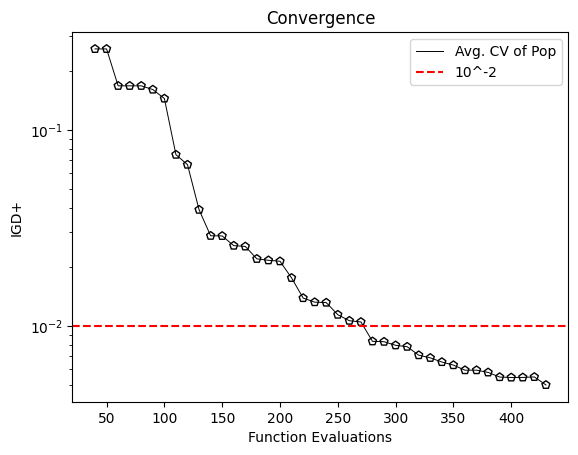

In [11]:
from pymoo.indicators.igd_plus import IGDPlus

metric = IGDPlus(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD+")
plt.yscale("log")
plt.legend()
plt.show()